In [746]:
# Video games are sold all over the world which produces a large amount of data on user and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales. The goal of this project is to identify patterns that determine whether a game succeeds or not. This will allow identification of potential big winners and which games to plan advertising campaigns for. 

In [747]:
# Import packages needed for analysis of data
import pandas as pd
import plotly.express as px
import re
from matplotlib import pyplot as plt 
import numpy as np 

In [ ]:
# Print info of DataFrame to get all attributes of table at once
DF = pd.read_csv("dataset.csv")
print(DF.info())

In [ ]:
# Rename column names to contain only lowercase letters
DF = DF.rename(
    columns={
        'Name': 'name',
        'Platform': 'platform',
        'Year_of_Release': 'year_of_release',
        'Genre': 'genre',
        'NA_sales': 'na_sales',
        'EU_sales': 'eu_sales',
        'JP_sales': 'jp_sales',
        'Other_sales': 'other_sales',
        'Critic_Score': 'critic_score',
        'User_Score': 'user_score',
        'Rating': 'rating'
    }
)

# Verify the change
print(DF.info())


In [ ]:
# Change the 'user_score' column from object to float to be able to conduct mathematical equations (ex: mean score, min score, max score, std score)
DF['user_score'] = pd.to_numeric(DF['user_score'], errors='coerce')

# Verify the change
print(DF.info())


In [ ]:
# Due to such a large dataset, it is not practical to display all the rows, thus we will print the first and last 5 rows.
# Print the first 5 rows for a small sample of data to give a quick snapshot of the structure of the dataset.
print(DF.head(5))

In [ ]:
# Print last 5 rows for another sample of data to check if there are any special cases, outliers, or null values that weren't visible at the beginning.
print(DF.tail(5))

In [ ]:
# Check for any duplicates
print(DF.duplicated().sum())

In [ ]:
# Find the total of missing values for each column
print(DF.isna().sum())

In [ ]:
# Make sure there are no TBD values for any of the columns before starting to assess missing values individually
value = DF.get('TBD', 'default_value')  # Returns 'default_value' if 'TBD' does not exist
print(value)

In [ ]:
# Check to see if the missing values for the games with no names is significant enough to keep in the dataset
missing_specific_name = DF[DF['name'].isnull()]
print(missing_specific_name)

# Because there are sales for the games with no names, will not drop them from the data set so as to have a more accurate analysis later on
# The names could be missing, again, due to human error with information entry and source limitations if the data was collected from multiple platforms and databases

In [ ]:
# Will change NaN to N/A for the 2 games with no names to maintain consistency and good practice
DF['name'] = DF['name'].fillna('N/A')

# Verify the changes
print(DF.isnull().sum())

In [ ]:
# Check to see if the year might be in the name of the game, if so we can use that information in a loop to place it in the year_of_release column
missing_specific_year= DF[DF['year_of_release'].isnull()]
print(missing_specific_year)

In [ ]:
# We now know there are a few games that have the year in the game title

# Loop through each row to extract year and update the year_of_release column
for index, row in DF.iterrows():
    game_name = row['name']
    if isinstance(game_name, str):  # Check if game_name is a string
        match = re.search(r'\b(\d{4})\b', game_name)
        if match:
            DF.at[index, 'year_of_release'] = str(match.group(1))  # Convert to string

# Display the DataFrame
print(DF)

In [ ]:
# Check to see how many missing values we now have in the year_of_release column
print(DF.isnull().sum())

In [ ]:
# Drop rows where 'year_of_release' is missing (NaN)
DF = DF.dropna(subset=['year_of_release'])

# Convert the 'year_of_release' column to numeric type (int)
DF['year_of_release'] = DF['year_of_release'].astype(int)

# Filter rows to keep only those between 1980 and 2017
DF = DF[(DF['year_of_release'] >= 1980) & (DF['year_of_release']<= 2017)]

# Verify the changes
print(DF.isnull().sum())

In [ ]:
# Need to calculate the total sales (the sum of sales for all regions) for each game and put these values in a separate column within the table
# First calculate the total sales
DF['total_sales'] = DF['na_sales'] + DF['eu_sales'] + DF['jp_sales'] + DF['other_sales']

# Group by 'name' and calculate the total sales per game and add back to main dataframe
num_sales = DF.groupby('name')['total_sales'].sum().reset_index()

# Verify the changes
print(DF)

In [ ]:
# How many games were released in different years
yearly_game_sales = DF.groupby('year_of_release')['name'].count()
print(yearly_game_sales)

In [764]:
# It is important to note there is a clear pattern of growth from 1980 to 2009. This would correlate with the development of technology and new gaming systems being produced and distributed globally. 
# The sudden decrease in game sales starting in 2010 can be a reflection of global economic patterns due to the 2008 Global Financial Crisis. 
# The Global Financial Crisis started in the U.S. (correlates to the na_sales column) with the collapse of the housing bubble, and multiple financial institutions claiming bankruptcies which lead to government bailouts. 
# Europe (correlates to the eu_sales column) was significantly affected due to the strong financial ties with the U.S. which led to a recession in several European countries. 
# Japan's (correlates to the jp_sales column) economy was already in a long term stagnation period, but the Global Financial Crisis worsened issues like deflation and low economic growth. 
# The rapid decrease in sales could possibly be attributed to the financial recovery of the 2008 Global Financial Crisis. 

In [ ]:
# How sales varied from platform to platform (sales are in USD million)
game_platform_count = DF.groupby('platform')['total_sales'].count()
print(game_platform_count.sort_values())

In [ ]:
# Taking the top 5 platforms and creating a distribution based off total sales per year

# Calculate total sales for each platform
total_sales_per_platform = DF.groupby('platform')['total_sales'].sum()

# Get the top 5 platforms by total sales
top_5_platforms = total_sales_per_platform.nlargest(5).index

# Filter the DF to include only the top 5 platforms
DF_top5 = DF[DF['platform'].isin(top_5_platforms)]

# Pivot filtered data to get platforms as columns
platform_sales_top5 = DF_top5.pivot_table(index='year_of_release', columns='platform',values='total_sales',aggfunc='sum')

# Plotting each platform
ax = platform_sales_top5.plot(
    kind='line',
    xlim=[1999, 2018],  # Setting the range for years
    ylim=[0, platform_sales_top5.max().max() + 100],  # Setting the range for sales in millions
    grid=True,
    linewidth=2, # Optional: line width for better visibility
)

plt.xticks(range(1999,2019,2), rotation=45)

plt.title("Top 5 Gaming Platforms: Sales Distribution Over the Years")
plt.xlabel("Years")
plt.ylabel("Sales in USD Millions")
plt.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# Find Platforms that used to be popular but now have zero sales

# List all unique platforms in the dataset
all_platforms = DF['platform'].unique()

#Calculate total sales per platform per year
platform_year_sales = DF.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()

# Identify platforms that had sales before 2017
popular_platforms_before_2017 = platform_year_sales[(platform_year_sales['year_of_release'] < 2017) & (platform_year_sales['total_sales'] > 0)]['platform'].unique()

# Identify platforms with sales data in 2017
platforms_in_2017 = platform_year_sales[platform_year_sales['year_of_release'] == 2017]['platform'].unique()

# Platforms that had entries before 2017 but are missing in 2017
popular_platforms_before_2017_set = set(popular_platforms_before_2017)
platforms_in_2017_set = set(platforms_in_2017)
missing_platforms_2017 = list(popular_platforms_before_2017_set - platforms_in_2017_set)
print("Platforms missing in 2017 that were once popular:", missing_platforms_2017)


In [ ]:
# Calculate lifespan for missing platforms

missing_platform_lifespan = platform_year_sales[platform_year_sales['platform'].isin(missing_platforms_2017)]
missing_platform_lifespan = missing_platform_lifespan.groupby('platform')['year_of_release'].agg(['min', 'max']).reset_index()
missing_platform_lifespan['lifespan_years'] = missing_platform_lifespan['max'] - missing_platform_lifespan['min']

# Print the lifespan of missing platforms
print(missing_platform_lifespan.sort_values(by='lifespan_years', ascending=False))

In [ ]:
# Now find how long it generally takes for new platforms to appear and old ones to fade

# Calculate the first and last apearance of each platform
platform_lifespan = DF.groupby('platform')['year_of_release'].agg(['min','max']).reset_index()
platform_lifespan.columns = ['platform', 'first_appearance', 'last_appearance']
platform_lifespan['lifespan'] = platform_lifespan['last_appearance'] - platform_lifespan['first_appearance']

# Check calculations
print(platform_lifespan)

In [ ]:
# Find the year when each platform first appeared
new_platforms = platform_lifespan[['platform', 'first_appearance']].sort_values(by='first_appearance')

# Calculate the intervals between new platform introductions
new_platforms['introduction_interval'] = new_platforms['first_appearance'].diff().fillna(0).astype(int)

# Check calculations
print(new_platforms)

In [ ]:
# Find the average length of time for new platforms to appear
average_interval = new_platforms['introduction_interval'].mean().astype(int)

# Display the average length of time for new platforms to appear
print(average_interval)

In [ ]:
# Take into consideration the standard deviation
average_interval_std = new_platforms['introduction_interval'].std()
print(average_interval_std)

print(f"The average length of time for new platforms to appear, and old ones to fade out, is about 1-2 years.")

In [786]:
# Moving forward we should only use data from 2000-2017, this is the time period where the most growth for sales and development of different platforms and games saw a surge of growth.

# Create the dataframe we will be focusing on moving forward
DF_new = DF[(DF['year_of_release'] >= 2005) & (DF['year_of_release']<= 2017)]

# Put the new dataframe in chronological order based on the year_of_release column
DF_new_sorted = DF_new.sort_values(by='year_of_release', ascending=True)

# Display new dataframe
print(DF_new_sorted)

                                           name platform  year_of_release  \
11842                                Still Life       XB             2005   
4203          Dance Dance Revolution: Mario Mix       GC             2005   
1578         Tamagotchi Connection: Corner Shop       DS             2005   
10463  Tom Clancy's Splinter Cell: Chaos Theory       GC             2005   
4215                        Destroy All Humans!       XB             2005   
...                                         ...      ...              ...   
14089                           Just Dance 2017     XOne             2017   
8009                            Just Dance 2017      Wii             2017   
14090                           Just Dance 2017     X360             2017   
10847                           Just Dance 2017     WiiU             2017   
11571                  Earth Defense Force 2017     X360             2017   

            genre  na_sales  eu_sales  jp_sales  other_sales  critic_score 

In [787]:
# Find which platforms are leading in sales within new dataframe
leading_platforms = DF_new_sorted.groupby(['platform'])['total_sales'].sum().reset_index()

# Display data for platform sales within the new dataframe
print(leading_platforms.sort_values(by='total_sales', ascending=False))

# The top 5 leading platforms in sales are Xbox360, PS3, Wii, Nintendo DS, and PS2

   platform  total_sales
14     X360       960.49
8       PS3       930.68
12      Wii       890.97
2        DS       784.57
7       PS2       448.42
9       PS4       312.32
10      PSP       282.93
0       3DS       257.70
5        PC       165.89
16     XOne       159.32
13     WiiU        82.19
15       XB        66.72
11      PSV        53.46
3       GBA        43.12
4        GC        41.03
6        PS         0.37
1        DC         0.06


In [788]:
# Which platforms are growing and which are shrinking

# Calculate the total annual sales for each platform
annual_platform_sales = DF_new_sorted.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()

# Display calculations
print(annual_platform_sales)

    platform  year_of_release  total_sales
0        3DS             2011        63.18
1        3DS             2012        51.12
2        3DS             2013        56.56
3        3DS             2014        43.95
4        3DS             2015        27.75
..       ...              ...          ...
115     XOne             2013        19.12
116     XOne             2014        53.25
117     XOne             2015        60.38
118     XOne             2016        26.50
119     XOne             2017         0.07

[120 rows x 3 columns]


In [789]:
# Pivot the data to see sales trends over time
sales_trend_pivot = annual_platform_sales.pivot(index='year_of_release', columns='platform', values='total_sales')

# Calculate year-over-year growth for each platform
sales_trend = sales_trend_pivot.pct_change()

# Determine if platforms are growing or shrinking based on recent years performance
platform_trend = sales_trend.mean().sort_values(ascending=False).reset_index()
platform_trend.columns = ['platform', 'average_growth']

# Display calculation
print(platform_trend)
# From this data the top growing platforms for the designated time period are PS4, Xbox360, DC, PC, XOne, PSV, PS3
# From the data the top shring platforms for the designated time period are Wii, WiiU, PS2, PSP, DS, XB, 3DS

   platform  average_growth
0       PS4        0.356500
1      X360        0.255627
2        DC        0.100000
3        PC        0.095506
4      XOne        0.090117
5       PSV        0.071978
6       PS3        0.011210
7        PS        0.000000
8       GBA       -0.103113
9        GC       -0.132861
10      3DS       -0.188405
11       XB       -0.203208
12       DS       -0.204820
13      PSP       -0.279341
14      PS2       -0.330334
15     WiiU       -0.332502
16      Wii       -0.343392


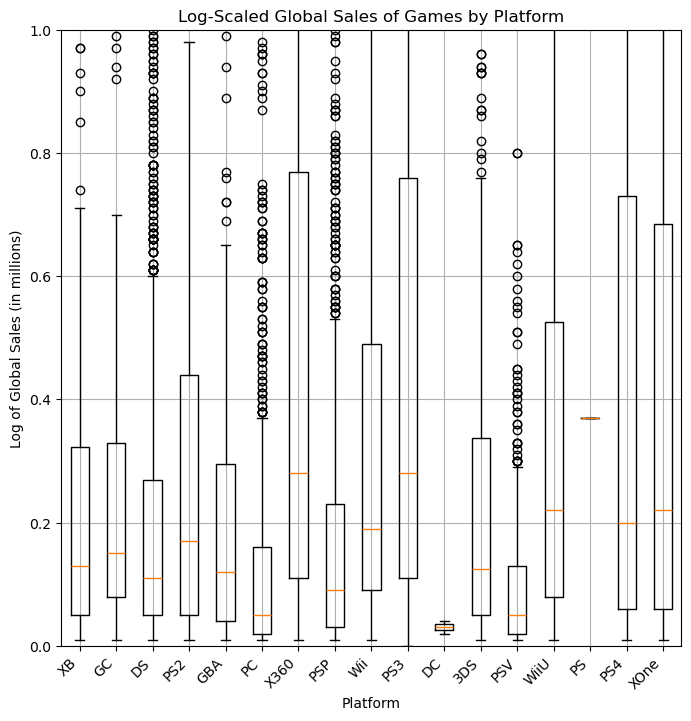

In [803]:
# Taking the global sales of all games from the new dataframe, create a boxplot

# Calculate the global sales for each platform
global_platform_sales = DF_new_sorted.groupby(['platform'])['total_sales'].sum().reset_index()

DF_new_sorted['log_total_sales'] = np.log1p(DF_new_sorted['total_sales'])

# Create a boxplot
plt.figure(figsize=(8, 8))
plt.boxplot([DF_new_sorted[DF_new_sorted['platform'] == platform]['total_sales'] for platform in DF_new_sorted['platform'].unique()],
            labels=DF_new_sorted['platform'].unique())
plt.title("Log-Scaled Global Sales of Games by Platform")
plt.xlabel("Platform")
plt.ylabel("Log of Global Sales (in millions)")
plt.grid(True)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.show()